In [2]:
import numpy as np
import pandas as pd
from scipy import sparse
import pymorphy2
import sys
sys.path.insert(0, '/home/mlepekhin/Non-thematic-Text-Classification/code/allennlp_experiments')
from data_processing import *
from models import *
from interpretation import *

In [3]:
genre_list = ['A1', 'A4', 'A7', 'A8', 'A9', 'A11', 'A12', 'A13', 'A14', 'A16', 'A17', 'A20']

def get_df_from_file(filename):
    df = pd.DataFrame()
    
    with open(filename) as fin:
        for line in fin:
            best_genre = genre_list[np.argmax(list(map(float, line.split('\t')[1:13])))]
            if best_genre not in ['A13', 'A20']:
                df = df.append({'text': ' '.join(line.split('\t')[13].split()[1:]), 'target': best_genre}, ignore_index=True)
    return df

df_names = [1, 2, 3, 4, 5, 6, 7, 8]
df_list = []

for df_name in df_names:
    df_list.append(get_df_from_file(f'/home/mlepekhin/data/manual_genres/{df_name}.csv'))

In [4]:
MODELS_DIR = '/home/mlepekhin/models'

transformer_model1 = 'xlm-roberta-base'
MODEL_ID1 = 'allennlp_xlm_roberta_enru_attacked_30_2'
CHECKPOINTS_DIR1 = pathjoin(MODELS_DIR, MODEL_ID1, 'checkpoints')
BEST_MODEL1 = pathjoin(CHECKPOINTS_DIR1, 'best.th')

transformer_model2 = 'DeepPavlov/rubert-base-cased'
MODEL_ID2 = 'rubert_enru_attacked_30' 
CHECKPOINTS_DIR2 = pathjoin(MODELS_DIR, MODEL_ID2, 'checkpoints')
BEST_MODEL2 = pathjoin(CHECKPOINTS_DIR2, 'best.th')

MAX_TOKENS = 512

In [5]:
!gpustat

seven                Mon Mar 15 18:00:34 2021  440.64
[0] TITAN RTX        | 38'C,   0 % |  4769 / 24220 MB | sharuev(2791M) sharuev(1965M)
[1] TITAN RTX        | 86'C,  99 % |  8342 / 24220 MB | cwb(2651M) cwb(2679M) cwb(3001M)
[2] TITAN RTX        | 34'C,   0 % |    11 / 24220 MB |
[3] TITAN RTX        | 87'C,  99 % |  9928 / 24220 MB | cwb(3411M) cwb(3063M) cwb(3443M)


In [6]:
vocab1 = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID1, 'vocab'))
model1 = build_pool_transformer_model(vocab1, transformer_model1)
model1.load_state_dict(torch.load(BEST_MODEL1, map_location='cpu'))

03152021 18:00:34|INFO|allennlp.data.vocabulary| Loading token dictionary from /home/mlepekhin/models/allennlp_xlm_roberta_enru_attacked_30_2/vocab.
03152021 18:00:34|INFO|filelock| Lock 140566004243040 acquired on /home/mlepekhin/models/allennlp_xlm_roberta_enru_attacked_30_2/vocab/.lock
03152021 18:00:34|INFO|filelock| Lock 140566004243040 released on /home/mlepekhin/models/allennlp_xlm_roberta_enru_attacked_30_2/vocab/.lock


Building the model


03152021 18:00:34|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /home/mlepekhin/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
03152021 18:00:34|INFO|transformers.configuration_utils| Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

03152021 18:00:35|INFO|transformers.modeling_util

<All keys matched successfully>

In [7]:
id_to_label1 = vocab1.get_index_to_token_vocabulary('labels')
label_to_id1 = vocab1.get_token_to_index_vocabulary('labels')
print(id_to_label1)
print(id_to_label1.values())

{0: 'A8', 1: 'A1', 2: 'A11', 3: 'A12', 4: 'A7', 5: 'A16', 6: 'A17', 7: 'A4', 8: 'A14', 9: 'A9', 10: 'A22'}
dict_values(['A8', 'A1', 'A11', 'A12', 'A7', 'A16', 'A17', 'A4', 'A14', 'A9', 'A22'])


In [8]:
vocab2 = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID2, 'vocab'))
model2 = build_transformer_model(vocab2, transformer_model2)
model2.load_state_dict(torch.load(BEST_MODEL2, map_location='cpu'))

03152021 18:00:50|INFO|allennlp.data.vocabulary| Loading token dictionary from /home/mlepekhin/models/rubert_enru_attacked_30/vocab.
03152021 18:00:50|INFO|filelock| Lock 140571714397760 acquired on /home/mlepekhin/models/rubert_enru_attacked_30/vocab/.lock
03152021 18:00:50|INFO|filelock| Lock 140571714397760 released on /home/mlepekhin/models/rubert_enru_attacked_30/vocab/.lock


Building the model


03152021 18:00:51|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/DeepPavlov/rubert-base-cased/config.json from cache at /home/mlepekhin/.cache/torch/transformers/b1ea51df212fa070e3a8a7d04dedb4800621e5a5bf504ecdb305faa622b46aa0.41d1cb30da8abef9028a44a17bd9c152daca0bd46e409bc271f324a28d109450
03152021 18:00:51|INFO|transformers.configuration_utils| Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "po

<All keys matched successfully>

In [9]:
id_to_label2 = vocab2.get_index_to_token_vocabulary('labels')
label_to_id2 = vocab2.get_token_to_index_vocabulary('labels')
print(id_to_label2)
print(id_to_label2.values())

{0: 'A8', 1: 'A1', 2: 'A11', 3: 'A12', 4: 'A7', 5: 'A16', 6: 'A17', 7: 'A4', 8: 'A14', 9: 'A9', 10: 'A22'}
dict_values(['A8', 'A1', 'A11', 'A12', 'A7', 'A16', 'A17', 'A4', 'A14', 'A9', 'A22'])


In [10]:
dataset_reader1 = build_transformer_dataset_reader(transformer_model1, MAX_TOKENS)
predictor1 = TextClassifierPredictor(model1, dataset_reader=dataset_reader1)

03152021 18:01:10|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /home/mlepekhin/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
03152021 18:01:10|INFO|transformers.configuration_utils| Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

03152021 18:01:11|INFO|transformers.tokenization_

In [11]:
dataset_reader2 = build_transformer_dataset_reader(transformer_model2, MAX_TOKENS)
predictor2 = TextClassifierPredictor(model2, dataset_reader=dataset_reader2)

03152021 18:01:17|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/DeepPavlov/rubert-base-cased/config.json from cache at /home/mlepekhin/.cache/torch/transformers/b1ea51df212fa070e3a8a7d04dedb4800621e5a5bf504ecdb305faa622b46aa0.41d1cb30da8abef9028a44a17bd9c152daca0bd46e409bc271f324a28d109450
03152021 18:01:17|INFO|transformers.configuration_utils| Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "po

In [12]:
from tqdm import tqdm

'''
all_predicted_probs1 = []
all_predicted_labels1 = []

for df in tqdm(df_list):
    predicted_probs = [predictor1.predict(text)['probs'] for text in df.text.values]
    predicted_labels = [id_to_label1[np.argmax(probs)] for probs in predicted_probs]
    all_predicted_probs1.append(predicted_probs[:])
    all_predicted_labels1.append(predicted_labels[:])'''

"\nall_predicted_probs1 = []\nall_predicted_labels1 = []\n\nfor df in tqdm(df_list):\n    predicted_probs = [predictor1.predict(text)['probs'] for text in df.text.values]\n    predicted_labels = [id_to_label1[np.argmax(probs)] for probs in predicted_probs]\n    all_predicted_probs1.append(predicted_probs[:])\n    all_predicted_labels1.append(predicted_labels[:])"

In [13]:
import pickle
#pickle.dump(all_predicted_probs1, open('xlm_roberta_probs_30_2.pkl', 'wb'))
all_predicted_probs1 = pickle.load(open('xlm_roberta_probs_30_2.pkl', 'rb'))

In [14]:
'''all_predicted_probs2 = []
all_predicted_labels2 = []

for df in tqdm(df_list):
    predicted_probs = [predictor2.predict(text)['probs'] for text in df.text.values]
    predicted_labels = [id_to_label2[np.argmax(probs)] for probs in predicted_probs]
    all_predicted_probs2.append(predicted_probs[:])
    all_predicted_labels2.append(predicted_labels[:])'''

"all_predicted_probs2 = []\nall_predicted_labels2 = []\n\nfor df in tqdm(df_list):\n    predicted_probs = [predictor2.predict(text)['probs'] for text in df.text.values]\n    predicted_labels = [id_to_label2[np.argmax(probs)] for probs in predicted_probs]\n    all_predicted_probs2.append(predicted_probs[:])\n    all_predicted_labels2.append(predicted_labels[:])"

In [15]:
#pickle.dump(all_predicted_probs2, open('rubert_k30_probs.pkl', 'wb'))
all_predicted_probs2 = pickle.load(open('rubert_k30_probs.pkl', 'rb'))

In [16]:
from sklearn.metrics import accuracy_score

all_targets = np.concatenate([df.target.values for df in df_list])
all_texts = np.concatenate([df.text.values for df in df_list])
all_names = np.concatenate([[df_name] * len(df) for df, df_name in zip(df_list, df_names)])

#all_predictions1 = np.concatenate(all_predicted_labels1)
total_probs1 = np.concatenate(all_predicted_probs1)

#all_predictions2 = np.concatenate(all_predicted_labels2)
total_probs2 = np.concatenate(all_predicted_probs2)

In [17]:
unique_labels = sorted(np.unique(pd.read_csv('/home/mlepekhin/data/en_train').target.values))

In [18]:
from classic_models import *

In [19]:
new_lr, new_vectorizer = load_model('lr_enru_noattacked')

In [20]:
id_to_label3 = {label_id: label for label_id, label in enumerate(new_lr.classes_)}
label_to_id3 = {label: label_id for label_id, label in enumerate(new_lr.classes_)}

In [21]:
all_predicted_probs3 = []
all_predicted_labels3 = []

for df in tqdm(df_list):
    predicted_probs = new_lr.predict_proba(new_vectorizer.transform(df.text.values))
    predicted_labels = [id_to_label3[np.argmax(probs)] for probs in predicted_probs]
    all_predicted_probs3.append(predicted_probs[:])
    all_predicted_labels3.append(predicted_labels[:])

100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


In [22]:
total_probs3 = np.concatenate(all_predicted_probs3)

In [23]:
total_probs4 = np.load('../../../../textattack_experiments/ru_lstm_attention/livejournal_probs.npy')

In [43]:
total_probs4.shape

(3553, 11)

In [48]:
def test_ensemble(alpha_xlm_roberta, alpha_rubert, alpha_lr, show_detailed_statistics=False):
    alpha_lstm = 1 - alpha_xlm_roberta - alpha_rubert
    normalized_probs1 = np.zeros_like(total_probs1).astype(float)
    normalized_probs2 = np.zeros_like(total_probs2).astype(float)
    normalized_probs3 = np.zeros_like(total_probs3).astype(float)
    normalized_probs4 = np.zeros_like(total_probs4).astype(float)
    
    for label_id, label in enumerate(unique_labels):
        normalized_probs1[:, label_id] = total_probs1[:, label_to_id1[label]]
        normalized_probs2[:, label_id] = total_probs2[:, label_to_id2[label]]
        normalized_probs3[:, label_id] = total_probs3[:, label_to_id3[label]]
    normalized_probs4 = total_probs4
        
    ensemble_probs = alpha_xlm_roberta * normalized_probs1
    ensemble_probs += alpha_rubert * normalized_probs2
    ensemble_probs += alpha_lr * normalized_probs3
    ensemble_probs += alpha_lstm * normalized_probs4
    
    
    ensemble_predictions = [unique_labels[label_id] for label_id in np.argmax(ensemble_probs, axis=1)]
    #print(ensemble_predictions)
    #print(all_targets)
    total_accuracy = accuracy_score(ensemble_predictions, all_targets)
    #print('overall accuracy', total_accuracy)
    
    if show_detailed_statistics:
        calc_classifier_metrics(np.array(ensemble_predictions), all_targets)
        plot_confusion_matrix(np.array(ensemble_predictions), all_targets)
        plt.show()
    
    return total_accuracy

label (argum) f1_score 0.4034582132564842 precision 0.6572769953051644 recall 0.2910602910602911
label (fictive) f1_score 0.6559139784946236 precision 0.7052023121387283 recall 0.6130653266331658
label (instruct) f1_score 0.6336 precision 0.8215767634854771 recall 0.515625
label (reporting) f1_score 0.9318695511785599 precision 0.9138695376820772 recall 0.950592885375494
label (legal) f1_score 0.5106382978723404 precision 0.36363636363636365 recall 0.8571428571428571
label (personal) f1_score 0.6991304347826087 precision 0.631083202511774 recall 0.783625730994152
label (commercial) f1_score 0.27205882352941174 precision 0.18137254901960784 recall 0.5441176470588235
label (research) f1_score 0.25806451612903225 precision 0.36363636363636365 recall 0.2
label (info) f1_score 0.5066666666666667 precision 0.46568627450980393 recall 0.5555555555555556
label (eval) f1_score 0.4318181818181818 precision 0.37254901960784315 recall 0.5135135135135135
accuracy 0.7171404446946242


/home/mlepekhin/Non-thematic-Text-Classification/code/allennlp_experiments/interpretation.py:90: RuntimeWarning: invalid value encountered in true_divide
  normed_cm = (cm.T / sums).T
03152021 18:10:07|INFO|numexpr.utils| Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
03152021 18:10:07|INFO|numexpr.utils| NumExpr defaulting to 8 threads.


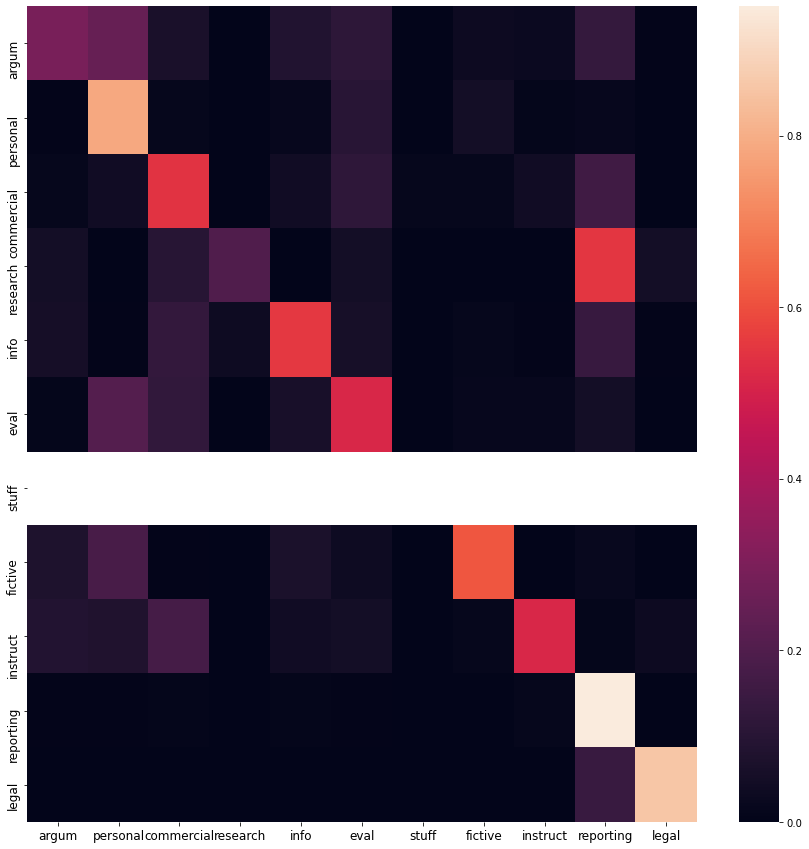

0.7171404446946242

In [49]:
test_ensemble(0, 1, 0, show_detailed_statistics=True)

label (argum) f1_score 0.4548959136468774 precision 0.36151960784313725 recall 0.6133056133056133
label (fictive) f1_score 0.18852459016393444 precision 0.5111111111111111 recall 0.11557788944723618
label (instruct) f1_score 0.08888888888888888 precision 0.8571428571428571 recall 0.046875
label (reporting) f1_score 0.8574132492113565 precision 0.822639225181598 recall 0.8952569169960475
label (legal) f1_score 0.14285714285714285 precision 0.08928571428571429 recall 0.35714285714285715
label (personal) f1_score 0.5963302752293579 precision 0.5632582322357019 recall 0.6335282651072125
label (commercial) f1_score 0.16949152542372883 precision 0.2 recall 0.14705882352941177
label (research) f1_score 0.0 precision 0.0 recall 0.0
label (info) f1_score 0.020100502512562814 precision 0.07142857142857142 recall 0.011695906432748537
label (eval) f1_score 0.2379958246346555 precision 0.19387755102040816 recall 0.3081081081081081
accuracy 0.5893611032929919


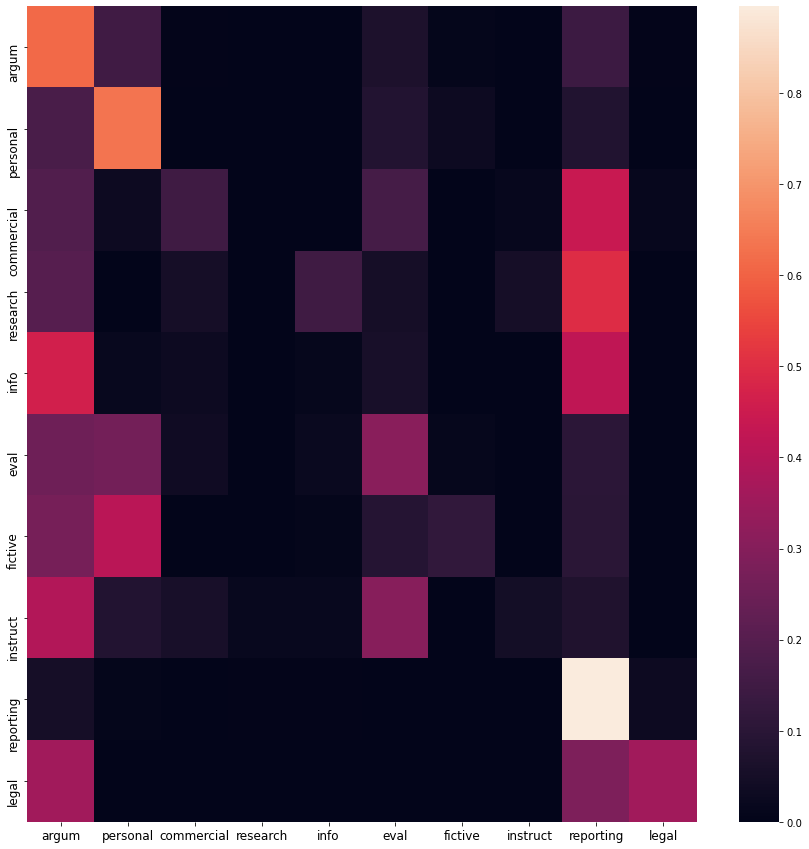

0.5893611032929919

In [50]:
test_ensemble(0, 0, 0, show_detailed_statistics=True)

label (argum) f1_score 0.5867861142217246 precision 0.6359223300970874 recall 0.5446985446985447
label (fictive) f1_score 0.6894586894586895 precision 0.7960526315789473 recall 0.6080402010050251
label (instruct) f1_score 0.7258278145695364 precision 0.738544474393531 recall 0.7135416666666666
label (reporting) f1_score 0.928919182083739 precision 0.9155470249520153 recall 0.9426877470355731
label (legal) f1_score 0.45901639344262296 precision 0.2978723404255319 recall 1.0
label (personal) f1_score 0.75591985428051 precision 0.7094017094017094 recall 0.8089668615984406
label (commercial) f1_score 0.30769230769230765 precision 0.25742574257425743 recall 0.38235294117647056
label (research) f1_score 0.3333333333333333 precision 0.5 recall 0.25
label (info) f1_score 0.6030927835051546 precision 0.5391705069124424 recall 0.6842105263157895
label (eval) f1_score 0.45000000000000007 precision 0.6631578947368421 recall 0.34054054054054056
accuracy 0.7678018575851393


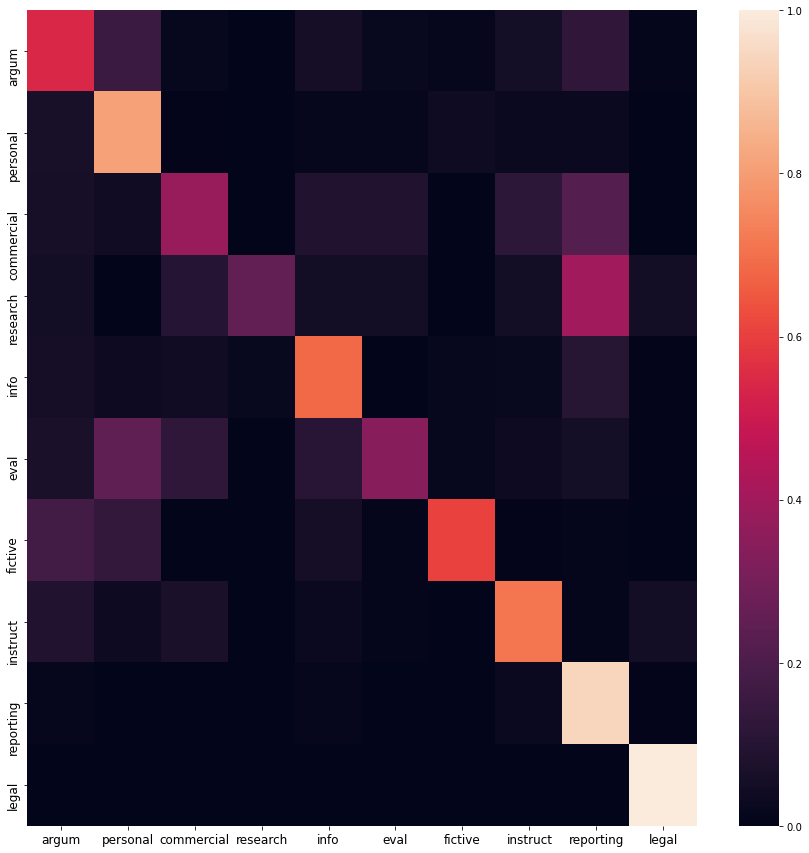

0.7678018575851393

In [51]:
test_ensemble(1, 0, 0, show_detailed_statistics=True)

label (argum) f1_score 0.5817782656421514 precision 0.6162790697674418 recall 0.5509355509355509
label (fictive) f1_score 0.6784660766961652 precision 0.8214285714285714 recall 0.5778894472361809
label (instruct) f1_score 0.717032967032967 precision 0.7587209302325582 recall 0.6796875
label (reporting) f1_score 0.9295865633074936 precision 0.9119138149556401 recall 0.9479578392621871
label (legal) f1_score 0.5185185185185185 precision 0.35 recall 1.0
label (personal) f1_score 0.7638640429338103 precision 0.7057851239669422 recall 0.8323586744639376
label (commercial) f1_score 0.33519553072625696 precision 0.2702702702702703 recall 0.4411764705882353
label (research) f1_score 0.3333333333333333 precision 0.5 recall 0.25
label (info) f1_score 0.5972602739726027 precision 0.5618556701030928 recall 0.6374269005847953
label (eval) f1_score 0.4755244755244756 precision 0.6732673267326733 recall 0.3675675675675676
accuracy 0.7692091190543203


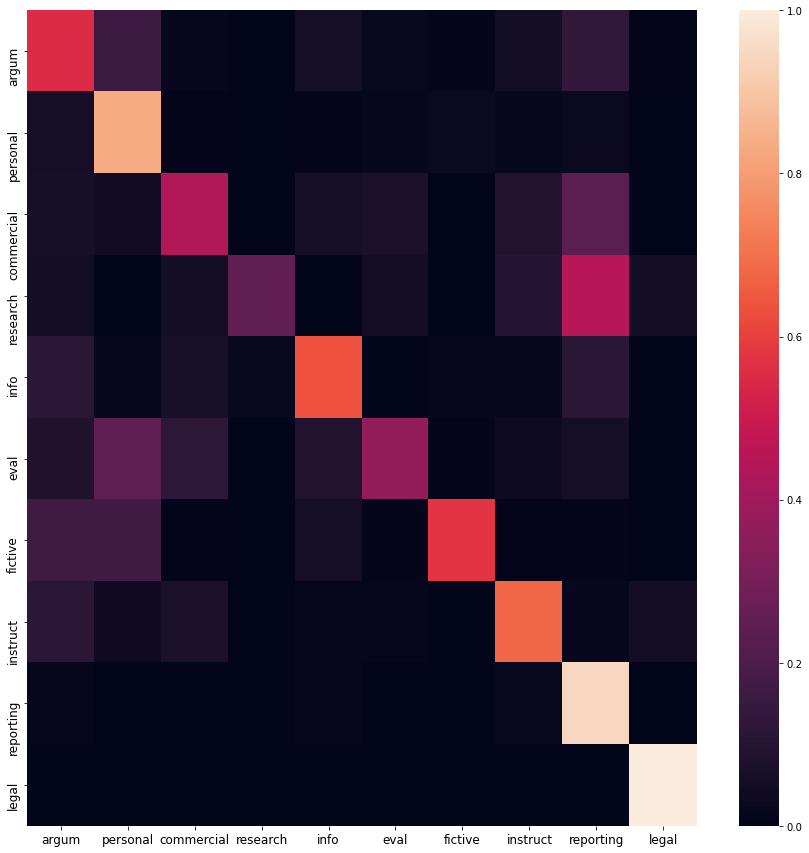

0.7692091190543203

In [52]:
test_ensemble(0.7, 0.1, 0.2, show_detailed_statistics=True)

In [30]:
best_coeff = (0, 0)
best_accuracy = 0

for i in np.linspace(0, 1, 100):
    for j in np.linspace(0, 1-i, 100):
        cur_acc = test_ensemble(i, j, 1 - i - j)
        if cur_acc > best_accuracy:
            best_accuracy = cur_acc
            best_coeff = (i, j, 1 - i - j)

(0.6842105263157894, 0.19944598337950142, 0.055110074354862246)
label (argum) f1_score 0.5854214123006833 precision 0.6473551637279596 recall 0.5343035343035343
label (fictive) f1_score 0.6898550724637682 precision 0.815068493150685 recall 0.5979899497487438
label (instruct) f1_score 0.7292517006802721 precision 0.7635327635327636 recall 0.6979166666666666
label (reporting) f1_score 0.9319135204904808 precision 0.9133459835547122 recall 0.9512516469038208
label (legal) f1_score 0.5283018867924528 precision 0.358974358974359 recall 1.0
label (personal) f1_score 0.7656529516994632 precision 0.7074380165289256 recall 0.834307992202729
label (commercial) f1_score 0.3448275862068966 precision 0.2830188679245283 recall 0.4411764705882353
label (research) f1_score 0.3333333333333333 precision 0.5 recall 0.25
label (info) f1_score 0.6084656084656085 precision 0.5555555555555556 recall 0.672514619883041
label (eval) f1_score 0.49324324324324326 precision 0.6576576576576577 recall 0.394594594594

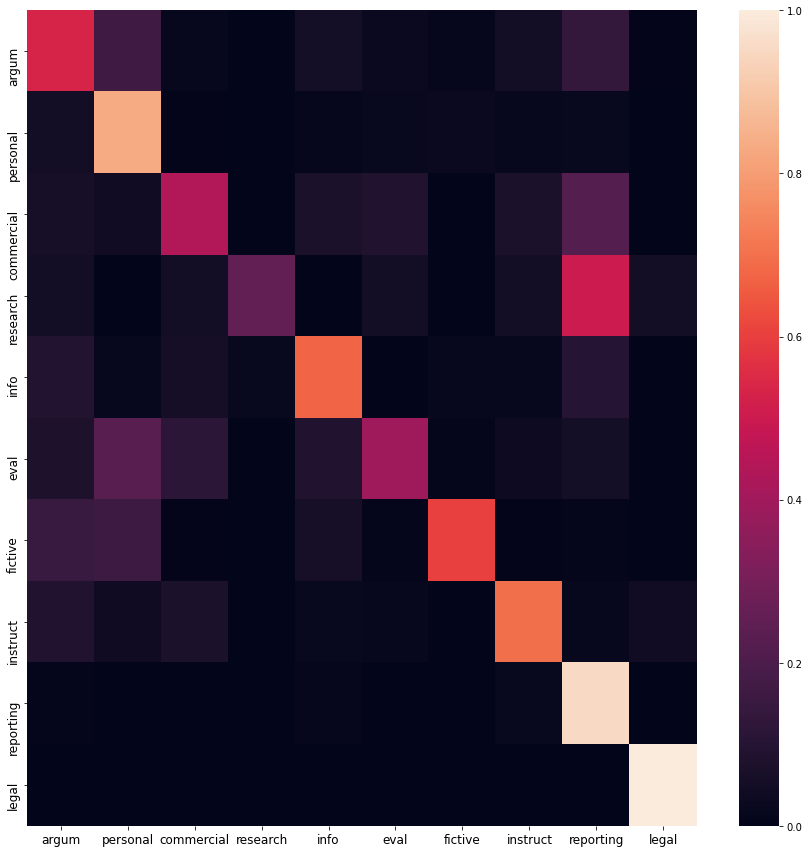

0.7748381649310442

In [53]:
print(best_coeff)
test_ensemble(*best_coeff, show_detailed_statistics=True)

In [54]:
best_coeff = (0, 0)
best_accuracy = 0

for i in np.linspace(0, 1, 100):
    cur_acc = test_ensemble(i, 0, 1 - i)
    if cur_acc > best_accuracy:
        best_accuracy = cur_acc
        best_coeff = (i, 0, 1 - i)

(0.9090909090909092, 0, 0.09090909090909083)
label (argum) f1_score 0.5933333333333334 precision 0.6372315035799523 recall 0.5550935550935551
label (fictive) f1_score 0.6782608695652174 precision 0.8013698630136986 recall 0.5879396984924623
label (instruct) f1_score 0.7304116865869854 precision 0.7452574525745257 recall 0.7161458333333334
label (reporting) f1_score 0.9303530936183997 precision 0.9152326322498406 recall 0.9459815546772069
label (legal) f1_score 0.49122807017543857 precision 0.32558139534883723 recall 1.0
label (personal) f1_score 0.7608695652173912 precision 0.7106598984771574 recall 0.8187134502923976
label (commercial) f1_score 0.31764705882352945 precision 0.2647058823529412 recall 0.39705882352941174
label (research) f1_score 0.3333333333333333 precision 0.5 recall 0.25
label (info) f1_score 0.6073298429319371 precision 0.5497630331753555 recall 0.6783625730994152
label (eval) f1_score 0.43884892086330934 precision 0.6559139784946236 recall 0.32972972972972975
accur

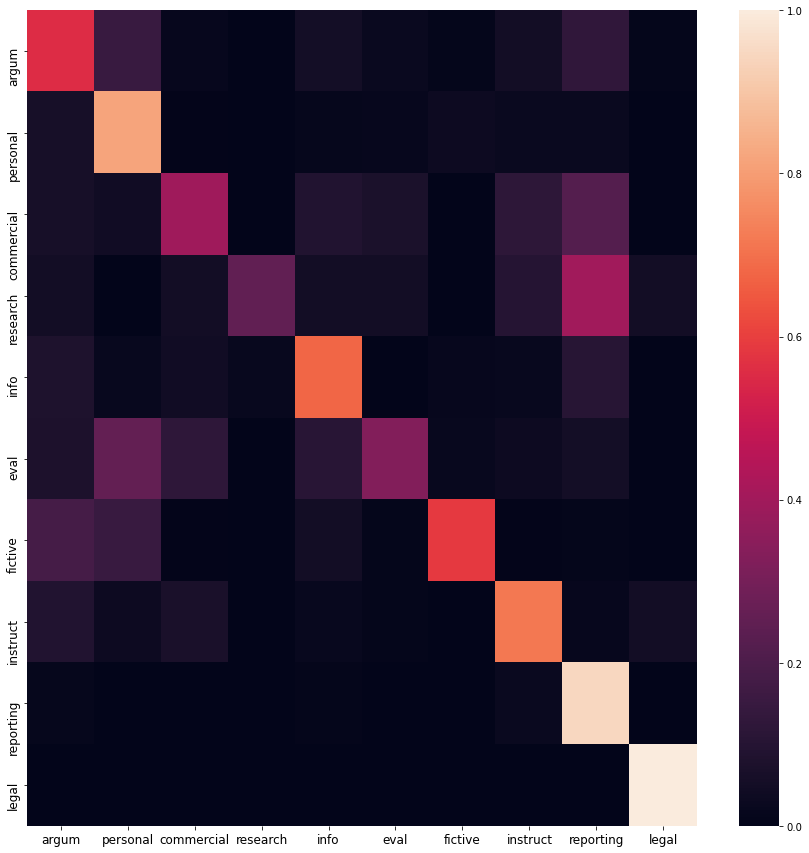

0.7706163805235012

In [55]:
print(best_coeff)
test_ensemble(*best_coeff, show_detailed_statistics=True)

In [56]:
best_coeff = (0, 0)
best_accuracy = 0

for i in tqdm(np.linspace(0, 1, 20)):
    for j in np.linspace(0, 1-i, 20):
        for l in np.linspace(0, 1-i-j, 20):
            cur_acc = test_ensemble(i, j, l)
            if cur_acc > best_accuracy:
                best_accuracy = cur_acc
                best_coeff = (i, j, l)
print(best_coeff)
print(best_accuracy)

100%|██████████| 20/20 [00:28<00:00,  1.45s/it]

(0.6842105263157894, 0.19944598337950142, 0.055110074354862246)
0.7748381649310442


(0.6842105263157894, 0.19944598337950142, 0.055110074354862246)
label (argum) f1_score 0.5854214123006833 precision 0.6473551637279596 recall 0.5343035343035343
label (fictive) f1_score 0.6898550724637682 precision 0.815068493150685 recall 0.5979899497487438
label (instruct) f1_score 0.7292517006802721 precision 0.7635327635327636 recall 0.6979166666666666
label (reporting) f1_score 0.9319135204904808 precision 0.9133459835547122 recall 0.9512516469038208
label (legal) f1_score 0.5283018867924528 precision 0.358974358974359 recall 1.0
label (personal) f1_score 0.7656529516994632 precision 0.7074380165289256 recall 0.834307992202729
label (commercial) f1_score 0.3448275862068966 precision 0.2830188679245283 recall 0.4411764705882353
label (research) f1_score 0.3333333333333333 precision 0.5 recall 0.25
label (info) f1_score 0.6084656084656085 precision 0.5555555555555556 recall 0.672514619883041
label (eval) f1_score 0.49324324324324326 precision 0.6576576576576577 recall 0.394594594594

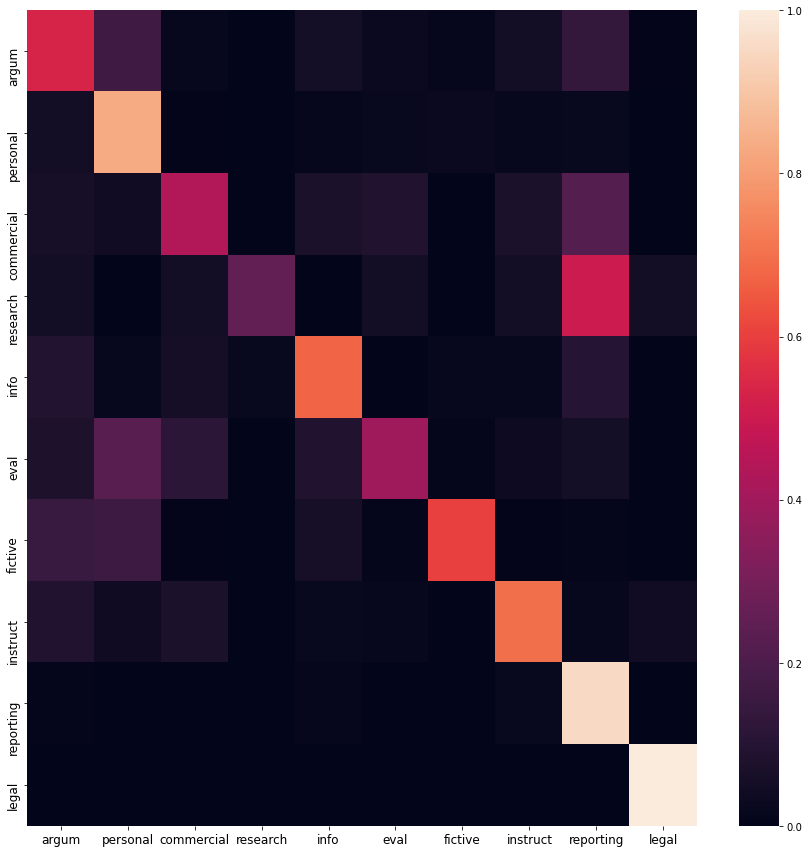

0.7748381649310442

In [57]:
print(best_coeff)
test_ensemble(*best_coeff, show_detailed_statistics=True)